# Day 11 - Part 1 - K Nearest-Neighbor Classifier

In [2]:
from datascience import *
import numpy as np

import matplotlib.pyplot as plots
from mpl_toolkits.mplot3d import Axes3D
plots.style.use('fivethirtyeight')
%matplotlib inline

## Defining a classifier

In [3]:
patients = Table.read_table('breast-cancer.csv').drop('ID')
patients.show(5)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
5,1,1,1,2,1,3,1,1,0
5,4,4,5,7,10,3,2,1,0
3,1,1,1,2,2,3,1,1,0
6,8,8,1,3,4,3,7,1,0
4,1,1,3,2,1,3,1,1,0


In [4]:
np.array(patients.drop('Class').row(0))

array([5, 1, 1, 1, 2, 1, 3, 1, 1])

In [5]:
def distance (pt1, pt2):
    return np.sqrt(np.sum((pt1 - pt2) ** 2))

def distance_rows(row1, row2):
    pt1 = np.array(patients.drop('Class').row(row1))
    pt2 = np.array(patients.drop('Class').row(row2))
    return distance(pt1, pt2)

distance_rows(1, 10)

12.96148139681572

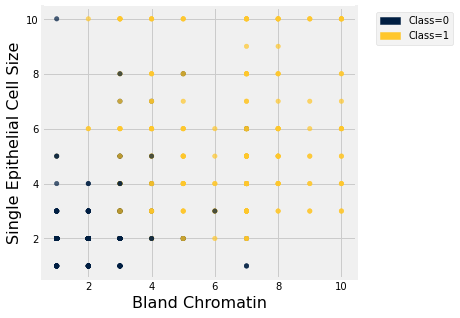

In [12]:
patients.scatter('Bland Chromatin', 'Single Epithelial Cell Size', group='Class')

In [ ]:
def randomize_column(a):
    return a + np.random.normal(0.0, 0.09, size=len(a))

jittered = Table().with_columns([
        'Bland Chromatin (jittered)', 
        randomize_column(patients.column('Bland Chromatin')),
        'Single Epithelial Cell Size (jittered)', 
        randomize_column(patients.column('Single Epithelial Cell Size')),
        'Class',
        patients.column('Class')
    ])

jittered.scatter(0, 1, colors='Class')

## Distance

In [ ]:
def distance(pt1, pt2):
    """The distance between two points, represented as arrays."""
    return np.sqrt(sum((pt1 - pt2) ** 2))

def row_distance(row1, row2):
    """The distance between two rows of a table."""
    return distance(np.array(row1), np.array(row2))

In [ ]:
attributes = patients.drop('Class')
attributes.show(3)

In [ ]:
row_distance(attributes.row(0), attributes.row(1))

In [ ]:
row_distance(attributes.row(0), attributes.row(0))

In [ ]:
row_distance(attributes.row(0), attributes.row(2))

## Classification Procedure

In [ ]:
def distances(training, example):
    """Compute the distance from example for each row in training."""
    dists = []
    attributes = training.drop('Class')
    for row in attributes.rows:
        dists.append(row_distance(row, example))
    return training.with_column('Distance', dists)

def closest(training, example, k):
    """Return a table of the k closest neighbors to example."""
    return distances(training, example).sort('Distance').take(np.arange(k))

In [ ]:
example = make_array(1, 5, 3, 0, 2, 2, 2, 2, 1)
classes = distances(patients, example).sort('Distance').take(np.arange(5)).group('Class').column(1)
classes
#if(classes.item(0) < classes.item(1)):
#    print('Cancer. DO more test!!')
#else:
#    print('You are ok')

In [ ]:
patients.take(12)

In [ ]:
example = patients.drop('Class').row(12)
example

In [ ]:
closest(patients.exclude(12), example, 5)

In [ ]:
def majority_class(top_k):
    """Return the class with the highest count."""
    return top_k.group('Class').sort('count', descending=True).column(0).item(0)

def classify(training, example, k):
    """Return the majority class among the k nearest neighbors."""
    return majority_class(closest(training, example, k))

In [ ]:
classify(patients.exclude(12), example, 5)

## Evaluation

In [ ]:
patients.num_rows

In [ ]:
shuffled = patients.sample(with_replacement=False) # Randomly permute the rows
trainset = shuffled.take(range(342))
testset  = shuffled.take(range(342, 683))

In [ ]:
def evaluate_accuracy(training, test, k):
    test_attributes = test.drop('Class')
    numcorrect = 0
    for i in range(test.num_rows):
        # Run the classifier on the ith patient in the test set
        c = classify(training, test_attributes.row(i), k)
        # Was the classifier's prediction correct?
        if c == test.column('Class').item(i):
            numcorrect = numcorrect + 1
    return numcorrect / test.num_rows

In [ ]:
evaluate_accuracy(trainset, testset, 5)

In [ ]:
evaluate_accuracy(trainset, testset, 1)

In [ ]:
evaluate_accuracy(trainset, trainset, 5)

In [ ]:
evaluate_accuracy(trainset, trainset, 1)

## Decision boundaries

In [ ]:
ckd = Table.read_table('ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
ckd.show(3)

In [ ]:
kidney = ckd.select('Hemoglobin', 'Glucose', 'Class')
kidney.scatter(0, 1, colors=2)
plots.scatter(13, 250, color='red', s=30)

In [ ]:
def show_closest(t, point):
    """Show closest training example to a point."""
    near = closest(t, point, 1).row(0)
    t.scatter(0, 1, colors='Class')
    plots.scatter(point.item(0), point.item(1), color='red', s=30)
    plots.plot([point.item(0), near.item(0)], [point.item(1), near.item(1)], color='k', lw=2)

show_closest(kidney, make_array(13, 250))

In [ ]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers)) / np.std(any_numbers)  

def standardize(t):
    """Return a table in which all columns of t are converted to standard units."""
    t_su = Table()
    for label in t.labels:
        t_su = t_su.with_column(label + ' (su)', standard_units(t.column(label)))
    return t_su

In [ ]:
kidney_su = standardize(kidney.drop('Class')).with_column('Class', kidney.column('Class'))
show_closest(kidney_su, make_array(-0.2, 1.8))

In [7]:
show_closest(kidney_su, make_array(-0.2, 1.3))

NameError: name 'show_closest' is not defined

In [8]:
show_closest(kidney_su, make_array(-0.2, 1))

NameError: name 'show_closest' is not defined

In [9]:
show_closest(kidney_su, make_array(-0.2, 0.9))

NameError: name 'show_closest' is not defined

In [10]:
def decision_boundary(t, k):
    """Decision boundary of a two-column + Class table."""
    t_su = standardize(t.drop('Class')).with_column('Class', t.column('Class'))
    decisions = Table(t_su.labels)
    for x in np.arange(-2, 2.1, 0.1):
        for y in np.arange(-2, 2.1, 0.1):
            predicted = classify(t_su, make_array(x, y), k)
            decisions.append([x, y, predicted])
    decisions.scatter(0, 1, colors='Class', alpha=0.4)
    plots.xlim(-2, 2)
    plots.ylim(-2, 2)
    t_su_0 = t_su.where('Class', 0)
    t_su_1 = t_su.where('Class', 1)
    plots.scatter(t_su_0.column(0), t_su_0.column(1), c='darkblue', edgecolor='k')
    plots.scatter(t_su_1.column(0), t_su_1.column(1), c='gold', edgecolor='k')
    
decision_boundary(kidney, 1)

NameError: name 'kidney' is not defined

In [11]:
decision_boundary(kidney, 5)

NameError: name 'kidney' is not defined

In [ ]:
decision_boundary(jittered, 1)

In [ ]:
decision_boundary(jittered, 5)

<img src = " ">